In [1]:
from __future__ import print_function, division
from collections import Counter
import os
import time
import json
import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# from jupyterthemes import jtplot
# jtplot.style(theme="chesterish")

src = "data"

In [2]:
t0 = time.clock()
info = pd.read_csv(os.path.join(src, "format1", "user_info_format1.csv"))
print('load user info\nruntime:', time.clock() - t0)

t0 = time.clock()
df = pd.read_csv(os.path.join(src, "format1", "user_log_format1.csv"))
print('\nload user log\nruntime:', time.clock() - t0)

t0 = time.clock()
crosstab_by_user_item_action = pd.crosstab([df.user_id, df.item_id], df.action_type)
print('\ncreate cross table\nruntime:', time.clock() - t0)

load user info
runtime: 0.341860842888

load user log
runtime: 60.5345353342

create cross table
runtime: 400.252934748


In [3]:
# merge the user infomation to the user log
data = pd.merge(df, info, how='left', on='user_id')
# slice 100,000 data to explore
crosstab_slice = crosstab_by_user_item_action.iloc[:100000, :]
# merge the user infomation to the cross table (user, item x action)
data_slice = pd.merge(crosstab_slice.reset_index(), info, how='outer', on=['user_id'])

0.0    285638
1.0    121670
2.0     10426
Name: gender, dtype: int64


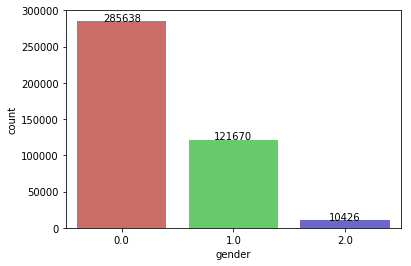

In [8]:
# Gender of user
print(info['gender'].value_counts())
fig = plt.figure()
sns.countplot(x='gender', data=info, palette='hls')
for i in range(3):
    plt.text(i, info['gender'].value_counts()[i], info['gender'].value_counts()[i], ha='center')
plt.show()
fig.savefig('image/gender.png')

3.0    111654
0.0     92914
4.0     79991
2.0     52871
5.0     40777
6.0     35464
7.0      6992
8.0      1266
1.0        24
Name: age_range, dtype: int64


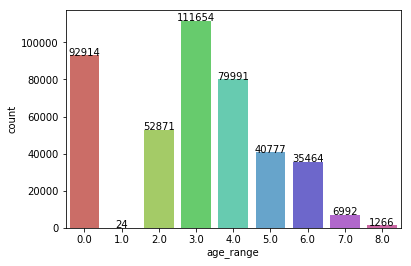

In [12]:
# Age Range of user
print(info['age_range'].value_counts())
fig = plt.figure()
sns.countplot(x='age_range', data=info, palette='hls')
for i in range(len(info['age_range'].value_counts())):
    plt.text(i, info['age_range'].value_counts()[i], info['age_range'].value_counts()[i], ha='center')
plt.show()
fig.savefig('image/age_range.png')

Text(0,0.5,'Frequency')

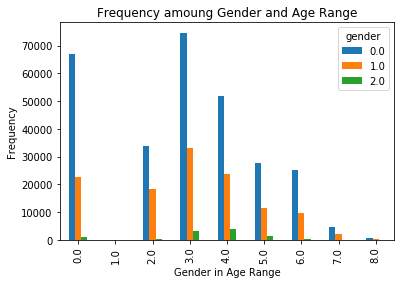

In [14]:
# Frequency amoung Gender and Age Range
pd.crosstab(info.age_range, info.gender).plot(kind='bar')
plt.title('Frequency amoung Gender and Age Range')
plt.xlabel('Gender in Age Range')
plt.ylabel('Frequency')

gender,0.0,1.0,2.0
action_type,,,
0,35547307,10814066,1817466
1,47719,23743,1297
2,2329907,811342,122478
3,2388245,486379,113886


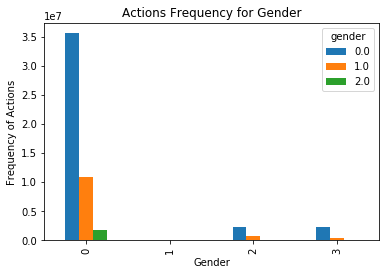

In [15]:
# Frequency of Actions to Gender
pd.crosstab(data.action_type, data.gender).plot(kind='bar')
plt.title('Actions Frequency for Gender')
plt.xlabel('Gender')
plt.ylabel('Frequency of Actions')
pd.crosstab(data.action_type, data.gender)

age_range,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0
action_type,,,,,,,,,
0,8805914,1512,4694010,13079874,10411758,5509918,4843730,945046,145456
1,23259,2,7230,18084,12386,6695,6279,1060,186
2,584369,96,295262,865659,769541,396683,308718,53932,9631
3,517620,111,388518,885020,608367,286704,254989,52227,7261


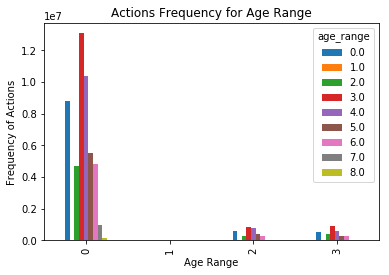

In [16]:
# Frequency of Actions to age
pd.crosstab(data.action_type, data.age_range).plot(kind='bar')
plt.title('Actions Frequency for Age Range')
plt.xlabel('Age Range')
plt.ylabel('Frequency of Actions')
pd.crosstab(data.action_type, data.age_range)

In [ ]:
crosstab_by_user_item_action[2]=np.where(crosstab_by_user_item_action[2] > 0, 1, crosstab_by_user_item_action[2])

In [87]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
x = []
y = []
for d in data:
    x += [[d[0], d[1], d[3]]]
    y += [[1 if d[2]>0 else 0]]

lr.fit(x, y)
print(lr.coef_)
print(lr.intercept_)

[[ 0.41630516 -1.28066333 -0.12869946]]
[-2.86266305]


C:\Anaconda2\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([[144,   0,   1],
       [111,   0,   0],
       [215,   0,   0],
       [173,   0,   0],
       [173,   0,   0]])

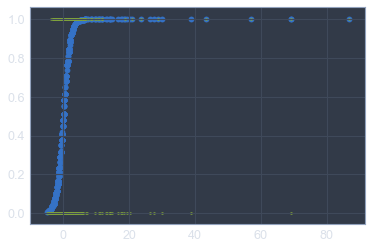

In [100]:
nx = np.array(x)
ny = np.array(y)

def sigmoid(x):
    return 1.0 / (1 + np.exp(-x))

nx_1 = np.concatenate((np.ones((nx.shape[0], 1)), nx), axis=1)
w = np.array([lr.intercept_[0]] + [wi for wi in lr.coef_[0]])

t = nx_1.dot(w)
p = sigmoid(t)

plt.scatter(t, p)
plt.scatter(t, ny, s=6)
# plt.axis([-10, 10, -.1, 1.1])
np.where(t>40)
nx[np.where(t>40)]

roc_auc_score:  0.5446580323779875
roc_auc_score:  0.5446580323779875


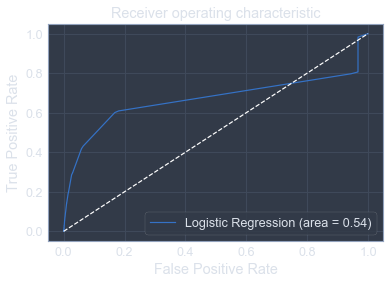

In [90]:
y_hat = lr.predict(nx)

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
# logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
# fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
print("roc_auc_score: ", roc_auc_score(ny, y_hat))
print("roc_auc_score: ", roc_auc_score(ny, lr.predict(nx)))

pred_prob = sigmoid(t) 

# fpr0, tpr0, thresholds0 = roc_curve(ny, pred_prob)
fpr1, tpr1, thresholds1 = roc_curve(ny, lr.predict_proba(nx)[:,1])

def roc_graph(fpr=fpr1, tpr=tpr1):
#     fig = plt.figure()
    plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % roc_auc_score(y, y_hat))
    plt.plot([0, 1], [0, 1],'w--')
    # plt.xlim([0.0, 1.0])
    # plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
#     plt.savefig('Log_ROC')
    plt.show()
#     return fig

roc_graph()